Model Accuracy: 1.00

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       274
           1       1.00      1.00      1.00       223

    accuracy                           1.00       497
   macro avg       1.00      1.00      1.00       497
weighted avg       1.00      1.00      1.00       497


ROC AUC Score: 1.00


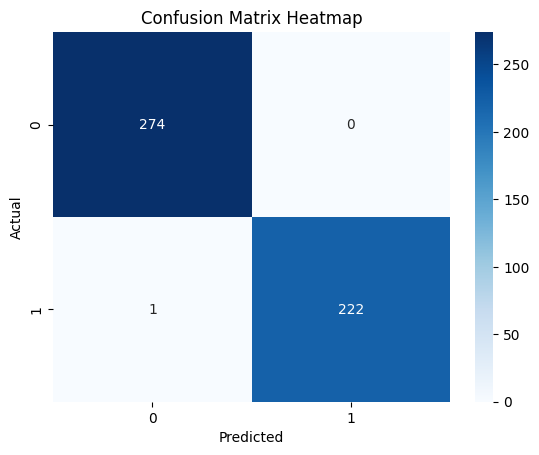

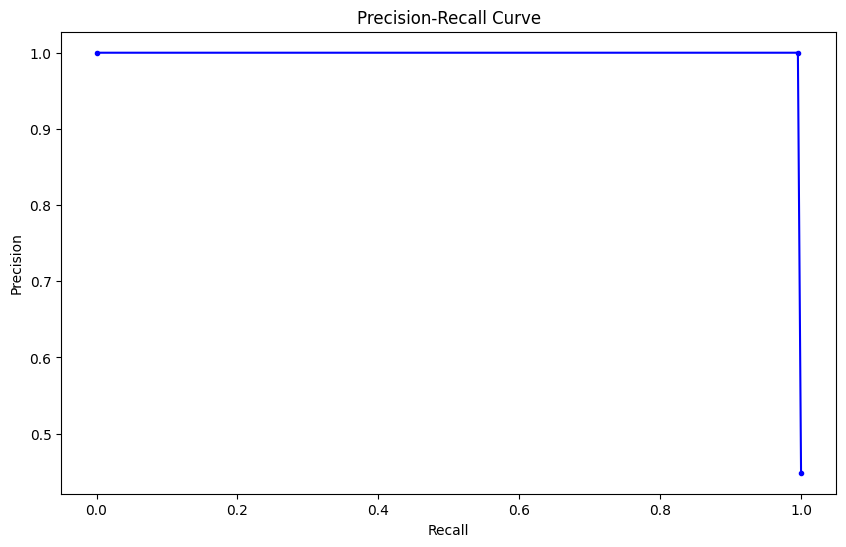

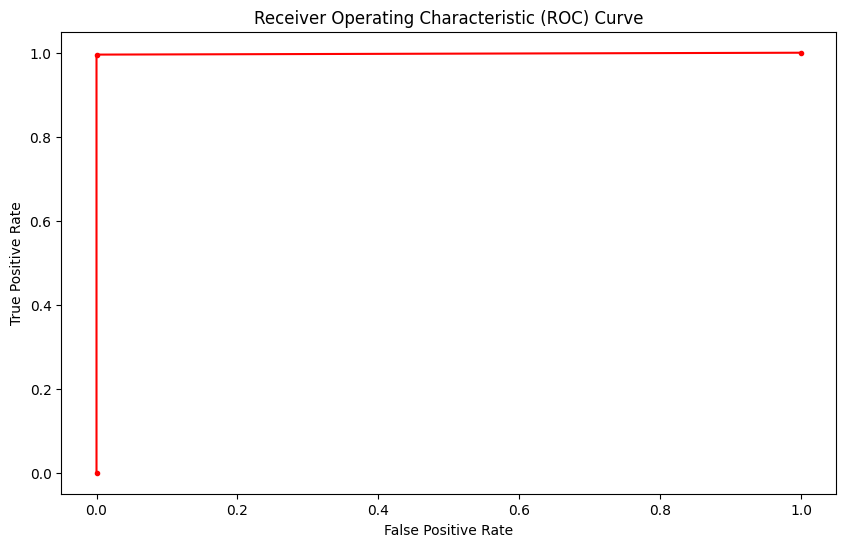

In [1]:
# Step 1: Load and Prepare Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Load Bitcoin (BIT) and Ethereum (ETH) datasets
btc_df = pd.read_csv('BIT_Dataset.csv')
eth_df = pd.read_csv('ETH_Dataset.csv')

# Convert 'Exchange Date' columns to datetime
btc_df['Exchange Date'] = pd.to_datetime(btc_df['Exchange Date'])
eth_df['Exchange Date'] = pd.to_datetime(eth_df['Exchange Date'])

# Merge datasets on the 'Exchange Date' column
data = pd.merge(btc_df, eth_df, on='Exchange Date', suffixes=('_BTC', '_ETH'))

# Drop rows with missing values in 'Exchange Date'
data.dropna(subset=['Exchange Date'], inplace=True)

# Convert relevant columns to numeric (removing commas and other characters)
for col in ['Bid_BTC', 'Ask_BTC', 'High_BTC', 'Low_BTC', 'Open_BTC', 'BidNet_BTC', 'Bid_ETH', 'Ask_ETH', 'High_ETH', 'Low_ETH', 'Open_ETH', 'BidNet_ETH', 'Refresh Rate_BTC', 'Refresh Rate_ETH']:
    data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', '').str.replace('[^0-9.-]', '', regex=True), errors='coerce')

# Impute missing values using the median strategy
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data.drop(columns=['Exchange Date'])), columns=data.columns[1:])
data = pd.concat([data[['Exchange Date']].reset_index(drop=True), data_imputed], axis=1)

# Step 2: Train the Model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Feature engineering - create target variable 'ETH_Target'
data['ETH_Target'] = (data['Bid_ETH'].shift(-1) > data['Bid_ETH']).astype(int)

# Drop the last row since it will have NaN target
data.dropna(inplace=True)

# Define features and target
features = data.drop(columns=['Exchange Date', 'ETH_Target'])
target = data['ETH_Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6]
}

gbm = GradientBoostingClassifier(random_state=42)
random_search = RandomizedSearchCV(gbm, param_distributions=param_dist, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Step 3: Make Predictions
# Train the best model
best_gbm = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_gbm.predict(X_test)

# Step 4: Evaluate Predictions
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

# Classification Report
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, best_gbm.predict_proba(X_test)[:, 1])
print(f'\nROC AUC Score: {roc_auc:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_gbm.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_gbm.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()


Model Accuracy: 0.52

Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.59      0.56       259
           1       0.49      0.43      0.46       238

    accuracy                           0.52       497
   macro avg       0.51      0.51      0.51       497
weighted avg       0.51      0.52      0.51       497


ROC AUC Score: 0.52


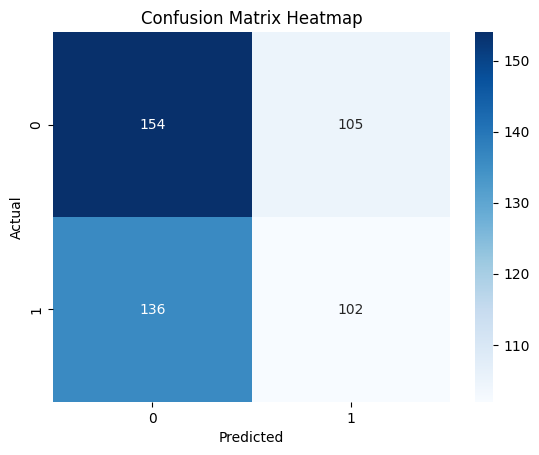

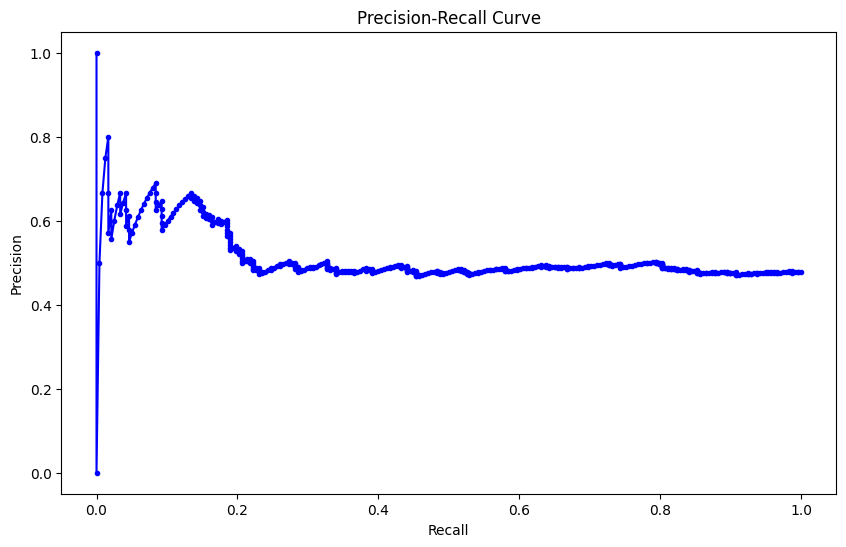

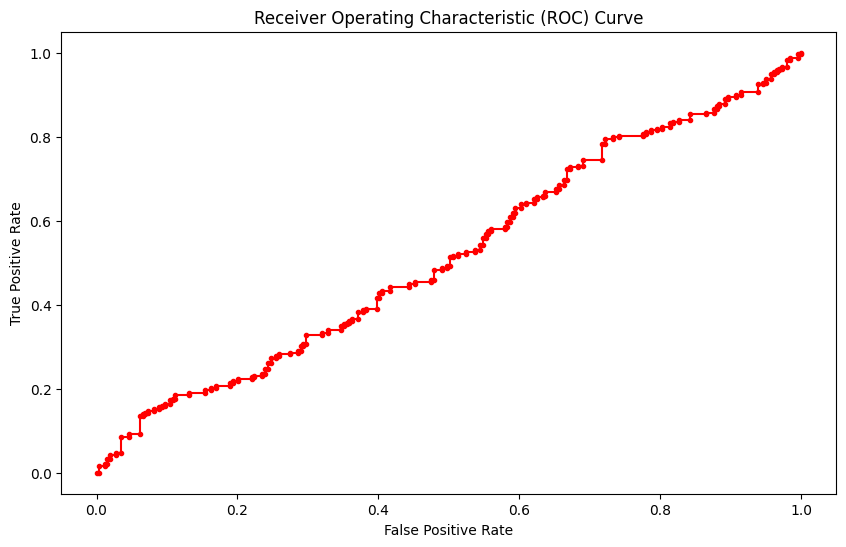

In [2]:
# Step 1: Load and Prepare Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Load Bitcoin (BIT) and Ethereum (ETH) datasets
btc_df = pd.read_csv('BIT_Dataset.csv')
eth_df = pd.read_csv('ETH_Dataset.csv')

# Convert 'Exchange Date' columns to datetime
btc_df['Exchange Date'] = pd.to_datetime(btc_df['Exchange Date'], errors='coerce')
eth_df['Exchange Date'] = pd.to_datetime(eth_df['Exchange Date'], errors='coerce')

# Drop rows with invalid 'Exchange Date'
btc_df.dropna(subset=['Exchange Date'], inplace=True)
eth_df.dropna(subset=['Exchange Date'], inplace=True)

# Merge datasets on the 'Exchange Date' column
data = pd.merge(btc_df, eth_df, on='Exchange Date', suffixes=('_BTC', '_ETH'))

# Convert relevant columns to numeric (removing commas and other characters)
numeric_cols = ['Bid_BTC', 'Ask_BTC', 'High_BTC', 'Low_BTC', 'Open_BTC', 'BidNet_BTC', 'Bid_ETH', 'Ask_ETH', 'High_ETH', 'Low_ETH', 'Open_ETH', 'BidNet_ETH']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', '').str.replace('[^0-9.-]', '', regex=True), errors='coerce')

# Drop columns with too many missing values
data.drop(columns=['Refresh Rate_BTC', 'Refresh Rate_ETH'], inplace=True, errors='ignore')

# Impute missing values in numeric columns using the median strategy
imputer = SimpleImputer(strategy='median')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# Step 2: Train the Model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Feature engineering - create target variable 'ETH_Target'
data['ETH_Target'] = (data['Bid_ETH'].shift(-1) > data['Bid_ETH']).astype(int)

# Drop the last row since it will have NaN target
data.dropna(inplace=True)

# Create lagged features for BTC and ETH data to prevent using future information
for col in ['Bid_BTC', 'Ask_BTC', 'High_BTC', 'Low_BTC', 'Open_BTC', 'BidNet_BTC', 'Bid_ETH', 'Ask_ETH', 'High_ETH', 'Low_ETH', 'Open_ETH', 'BidNet_ETH']:
    data[f'{col}_lag_1'] = data[col].shift(1)
    data[f'{col}_lag_2'] = data[col].shift(2)

# Drop rows with NaN values introduced by lagging
data.dropna(inplace=True)

# Ensure all numeric columns are properly formatted
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop any remaining rows with NaN values
data.dropna(inplace=True)

# Define features and target
lagged_features = [f'{col}_lag_1' for col in numeric_cols] + [f'{col}_lag_2' for col in numeric_cols]
features = data[lagged_features]
target = data['ETH_Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Ensure there are no NaN values in the training and testing sets
if X_train.isna().sum().sum() > 0 or X_test.isna().sum().sum() > 0:
    raise ValueError("Training or testing data contains NaN values after imputation.")

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6]
}

gbm = GradientBoostingClassifier(random_state=42)
random_search = RandomizedSearchCV(gbm, param_distributions=param_dist, n_iter=10, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Step 3: Make Predictions
# Train the best model
best_gbm = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_gbm.predict(X_test)

# Step 4: Evaluate Predictions
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

# Classification Report
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, best_gbm.predict_proba(X_test)[:, 1])
print(f'\nROC AUC Score: {roc_auc:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_gbm.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_gbm.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
